In [151]:
# -------
# IMPORT LIBRAIRIES
# -------
import numpy as np
import pandas as pd
from python_module.pricing_model import SABRModel
from python_module.tools import maximize_with_bounds

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.float_format = '{:,.2f}'.format

In [172]:
# -------
# INPUTS
# -------

# Pricing parameters
F     = 5000
alpha = 0.25
beta  = 1.0
rho   = -0.
nu    = 1.5
r     = 0
bd = 20
tail_bd = 20

# Scenario parameters
scenario_min = -0.3
scenario_max = 0.3
scenario_step = 0.05

option_strikes = [-0.3, -0.1, -0.05, 0.05, 0.1, 0.2, 0.3]
flat_scenarios = [-0.3, -0.1, -0.05, 0.05, 0.1, 0.2, 0.3]
target_scenario = 0.0

In [174]:
# Scenario parameters
num = int((scenario_max-scenario_min)/0.01 + 1)
slide_to_compute = list(np.round(np.linspace(start=scenario_min, stop=scenario_max, num=num), 2))


strike_list = []
T = bd / 250
for delta in [-0.01, -0.1, -0.2, -0.3, -0.4, 0.4, 0.3, 0.2, 0.1, 0.01]:
    option_type = 'call' if delta > 0 else 'put'
    K = SABRModel.solve_delta_strike(F=F, T=T, alpha=alpha, beta=beta, rho=rho, nu=nu, r=r, option_type=option_type, target_delta=delta)
    K = int(K)
    strike_list.append(K)
strike_list.append(F)
strike_list = sorted(strike_list)

market_data_list = list()
for K in strike_list:

    option_type = 'call' if K >= F else 'put'
    
    market_pricing_results = SABRModel.compute_option(F, K, T, alpha, beta, rho, nu, r, option_type, slide_list=slide_to_compute)

    market_data_list.append({
        'symbol': f"{bd}T_{K}K_{option_type}",
        'option_type': option_type, 
        'time_to_maturity': bd, 
        'F':F, 'r': r, 'F': F, 'K': K, 'T': T, **market_pricing_results})

market_data_df = pd.DataFrame(market_data_list)
market_data_df = market_data_df.set_index('symbol')

In [176]:
market_data_df = market_data_df.drop(0, axis=1).rename(columns={'theta': 0})

In [178]:
# OTM Scenarios
scenarios = market_data_df.loc[:, [target_scenario] + flat_scenarios]
scenarios = scenarios.sort_index(axis=1)
scenarios = scenarios.transpose()

In [180]:
df = scenarios.transpose().drop(target_scenario, axis=1)
s = scenarios.transpose()[target_scenario]

In [182]:
# Constrain weights between -0.5 and 0.8
w_opt, res = maximize_with_bounds(df=df, s=s, w_min=-10000, w_max=10000)

print("Optimal weights:\n", w_opt)
print("Maximized objective (w^T s):", float(w_opt.dot(s)))

Optimal weights:
 symbol
20T_4339K_put      2,919.98
20T_4564K_put    -10,000.00
20T_4716K_put     10,000.00
20T_4828K_put      6,825.71
20T_4926K_put    -10,000.00
20T_5000K_call   -10,000.00
20T_5104K_call     9,567.43
20T_5206K_call     8,884.81
20T_5324K_call   -10,000.00
20T_5516K_call     1,538.69
20T_5815K_call       659.95
Name: weights, dtype: float64
Maximized objective (w^T s): 46.52535224534208


In [184]:
portfolio_scenario = market_data_df.loc[:, slide_to_compute].multiply(w_opt, axis=0).sum().sort_index()

In [186]:
import plotly.express as px

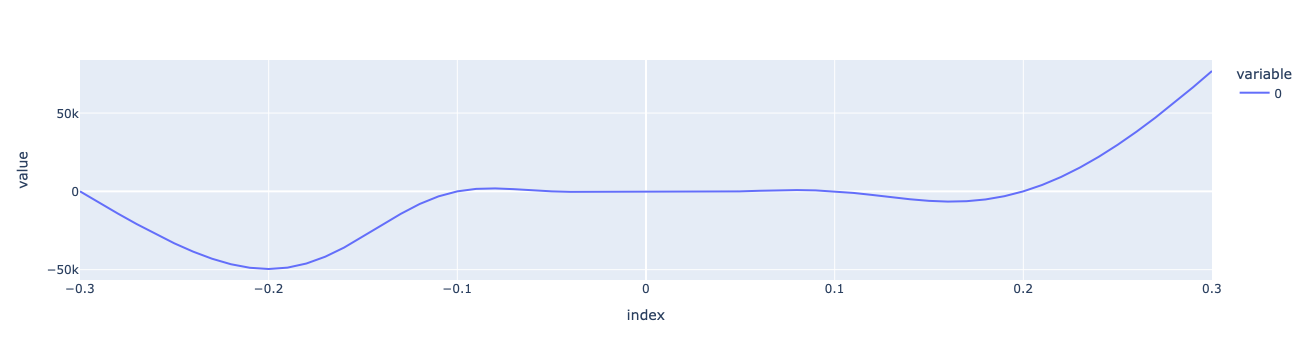

In [188]:
px.line(portfolio_scenario)